# Tutorial: Extracting Images for Transistors from PDF Datasheets

# Introduction

We will walk through the process of using `Fonduer` to extract images from [**richly formatted** data](https://hazyresearch.github.io/snorkel/blog/fonduer.html), where information is conveyed via combinations of textual, structural, tabular, and visual expressions, as seen in webpages, business reports, product specifications, and scientific literature.

In this tutorial, we use `Fonduer` to identify mentions of the image of transistors in a corpus of transistor datasheets from [Digikey.com](https://www.digikey.com/products/en/discrete-semiconductor-products/transistors-bipolar-bjt-single/276).

The tutorial only contains two parts:

1. KBC Initialization
2. Candidate Generation

# Phase 1: KBC Initialization

In this first phase of `Fonduer`'s pipeline, `Fonduer` uses a user specified _schema_ to initialize a relational database where the output KB will be stored. Furthermore, `Fonduer` iterates over its input _corpus_ and transforms each document into a unified data model, which captures the variability and multimodality of richly formatted data. This unified data model then servers as an intermediate representation used in the rest of the phases.

This preprocessed data is saved to a database. The connection string to the database is provided to the `Meta` object, which will initialize a PostgreSQL database for parallel execution.

We initialize several variables for convenience that define what the database should be called and what level of parallelization the `Fonduer` pipeline will be run with.

Before you continue, please make sure that you have PostgreSQL installed and have created a new database named `stg_temp_max_figure`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import logging

# Configure logging for Fonduer
logging.basicConfig(stream=sys.stdout, format='[%(levelname)s] %(name)s - %(message)s')
log = logging.getLogger('fonduer')
log.setLevel(logging.INFO)

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "stg_temp_max_figure"
conn_string = 'postgresql://localhost:5432/' + ATTRIBUTE

## 1.1 Parsing and Transforming the Input Documents into Unified Data Models

We first initialize a `Meta` object, which manages the connection to the database automatically, and enables us to save intermediate results.

In [2]:
from fonduer import Meta

session = Meta.init(conn_string).Session()

[INFO] fonduer.meta - Connecting user:None to localhost:5432/stg_temp_max_figure


[INFO] fonduer.meta - Initializing the storage schema


Next, we load the corpus of datasheets and transform them into the unified data model. Each datasheet has a PDF and HTML representation (in this example, the HTML is created using Adobe Acrobat). Both representations are used in conjunction to create a robust unified data model with textual, structural, tabular, and visual modality information. Note that since each document is independent of each other, we can parse the documents in parallel. We depend on PostgreSQL for this functionality.

### Configuring an `HTMLDocPreprocessor`
We start by setting the paths to where our documents are stored, and defining a `HTMLDocPreprocessor` to read in the documents found in the specified paths. `max_docs` specified the number of documents to parse. For the sake of this tutorial, we only look at 100 documents.

**Note that you need to have run `download_data.sh` before executing these next steps or you won't have the documents needed for the tutorial.**

In [3]:
from fonduer.parser.preprocessors import HTMLDocPreprocessor
from fonduer.parser import Parser

docs_path = 'data/html/'
pdf_path = 'data/pdf/'

max_docs = 4
doc_preprocessor = HTMLDocPreprocessor(docs_path, max_docs=max_docs)

### Configuring a `Parser`
Next, we configure a `Parser`, which serves as our `CorpusParser` for PDF documents. We use [spaCy](https://spacy.io/) as a preprocessing tool to split our documents into sentences and tokens, and to provide annotations such as part-of-speech tags and dependency parse structures for these sentences. In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable all modality information.

In [4]:
corpus_parser = Parser(session, structural=True, lingual=True, visual=True, pdf_path=pdf_path, flatten=[])
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=4), HTML(value='')))


CPU times: user 2.78 s, sys: 552 ms, total: 3.34 s
Wall time: 11min 36s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which `Fonduer` uses) to check how many documents and sentences were parsed, or even check how many sentences and figures are contained in each document.

In [5]:
from fonduer.parser.models import Document, Sentence, Figure

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())
print("Figures:", session.query(Figure).count())

Documents: 4
Sentences: 36562
Figures: 450


## 1.3 Dividing the Corpus into Test and Train

We'll split the documents 2/1/1 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [6]:
docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_docs = set()
dev_docs   = set()
test_docs  = set()
splits = (0.5, 0.75)
data = [(doc.name, doc) for doc in docs]
data.sort(key=lambda x: x[0])
for i, (doc_name, doc) in enumerate(data):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)
from pprint import pprint
pprint([x.name for x in train_docs])

['lmp2014mt', 'lmp2011']


# Phase 2: Mention Extraction, Candidate Extraction Multimodal Featurization

Given the unified data model from Phase 1, `Fonduer` extracts relation
candidates based on user-provided **matchers** and **throttlers**. Then,
`Fonduer` leverages the multimodality information captured in the unified data
model to provide multimodal features for each candidate.

## 2.1 Mention Extraction

The first step is to extract **mentions** from our corpus. A `mention` is the
type of object which makes up a `candidate`. For example, if we wanted to
extract pairs of transistor part numbers and their corresponding maximum
storage temperatures, the transistor part number would be one `mention` while
the temperature value would be another. These `mention`s are then combined to
create `candidates`, where our task is to predict which `candidates` are true
in the associated document.

We first start by defining and naming our `mention`:

In [7]:
from fonduer.candidates.models import mention_subclass

Fig = mention_subclass("Fig")

Next, we write **matchers** to define which spans of text in the corpus are
instances of each entity. Matchers can leverage a variety of information from
regular expressions, to dictionaries, to user-defined functions. Furthermore,
different techniques can be combined to form higher quality matchers. In
general, matchers should seek to be as precise as possible while maintaining
complete recall. More documentation about Matchers can be found on [Read the Docs](https://fonduer.readthedocs.io/en/stable/user/candidates.html#matchers).

In our case, we need to write a matcher that defines a transistor part number
and a matcher to identify images in a document.

### Writing a image matcher

Our image matcher can be a very simple since we want to search all images in the documents. More advanced matchers can be defined by users.

In [8]:
from fonduer.candidates.matchers import LambdaFunctionFigureMatcher

def do_nothing_matcher(fig):
    return True

fig_matcher = LambdaFunctionFigureMatcher(func=do_nothing_matcher)

### Define a relation's `MentionSpaces`

Next, in order to define the "space" of all mentions that are even considered
from the document, we need to define a `MentionSpace` for each component of the
relation we wish to extract. Fonduer provides a default `MentionSpace` for you
to use, but you can also extend the default `MentionSpace` depending on your
needs.

In the case of transistor images, the `MentionSpace` can be all png images.

When no special preproessing like this is needed, we could have used the default `MentionFigures` class provided by `fonduer`.

In [9]:
from fonduer.candidates import MentionFigures

figs = MentionFigures(types=['png'])

### Running Mention Extraction 

Next, we create a `MentionExtractor` to extract the mentions from all of
our documents based on the `MentionSpace` and matchers we defined above.

In [10]:
from fonduer.candidates import MentionExtractor 

mention_extractor = MentionExtractor(session, [Fig], [figs], [fig_matcher], parallelism=PARALLEL)

from fonduer.candidates.models import Mention

mention_extractor.apply(docs)

print("Total Mentions: {}".format(session.query(Mention).count()))

[INFO] fonduer.candidates.mentions - Clearing table: fig
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=4), HTML(value='')))


Total Mentions: 450


## 2.2 Candidate Extraction

Now that we have both defined and extracted the Mentions that can be used to compose Candidates, we are ready to move on to extracting Candidates. Like we did with the Mentions, we first define what each candidate schema looks like. In this example, we create a candidate that is composed of just a `Fig`.

In [11]:
from fonduer.candidates.models import candidate_subclass

FigCand = candidate_subclass("FigCand", [Fig])

In [12]:
from fonduer.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor(session, [FigCand], throttlers=[None], parallelism=PARALLEL)

%time candidate_extractor.apply(train_docs, split=0)

[INFO] fonduer.candidates.candidates - Clearing table fig_cand (split 0)
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=2), HTML(value='')))


CPU times: user 68 ms, sys: 56 ms, total: 124 ms
Wall time: 2.52 s


Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [13]:
train_cands = session.query(FigCand).filter(FigCand.split == 0).order_by(FigCand.id).all()
print("Number of candidates:", len(train_cands))

Number of candidates: 226


### Repeating for development and test splits
Finally, we rerun the same operation for the other two document divisions: dev and test. For each, we simply load the `Corpus` object and run them through the `CandidateExtractor`.

In [14]:
%%time
for i, docs in enumerate([dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i+1)
    print("Number of candidates:", session.query(FigCand).filter(FigCand.split == i+1).count())

[INFO] fonduer.candidates.candidates - Clearing table fig_cand (split 1)
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


Number of candidates: 73
[INFO] fonduer.candidates.candidates - Clearing table fig_cand (split 2)
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


Number of candidates: 151
CPU times: user 108 ms, sys: 152 ms, total: 260 ms
Wall time: 4.42 s


FigCand(Fig(Image(Doc: lmp2014mt, Position: 85, Url: lmp2014mt/Image_086.png)))


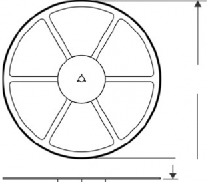

In [21]:
from IPython.display import Image

n = 33

print(train_cands[n])
Image(docs_path + '/' + train_cands[n][0].span.url, format='png')

TBD...